
- 20240536 Inês Jacinto 20240536@novaims.unl.pt
- 20240561 Antônio Ramos 20240561@novaims.unl.pt 
- 20240598 Sofia Jacinto 20240598@novaims.unl.pt 
- 20240750 Marisa Marques 20240750@novaims.unl.pt


### Imports

In [1]:
# General Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn packages
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy import stats

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report

from utils import *
from utils_data import *

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
# Set verbose flags for controlling the level of output during analysis and plotting
verbose = True
verbose_2 = False

In [4]:
# We want to predict Claim Injury Type

In [5]:
# Neeed to create utils.py, model.py and a way to store/load the trained models.

### EDA will consiste of:
    - In-depth exploration of the dataset.
    - Feature creation, in order to better explain the information
    - Find trends, patterns or anomalities.


In [6]:
# For this study we will consider all dates in reference to 25 of Dec of 2023
reference_date = pd.to_datetime("2023-12-25")

### Import Train dataset and view

In [7]:
# Load the training and test datasets from CSV files
test_df = pd.read_csv("test_data.csv", index_col="Claim Identifier")
train_df = pd.read_csv("train_data.csv", index_col="Claim Identifier")

In [9]:
# Display the first few rows of the training dataset for an overview
train_df.head()

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
Claim Identifier,,,,,,,,,,,,,,,,,,,,,
5393875,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,...,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
5393091,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,...,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
5393889,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,...,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
957648180,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5393887,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,...,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0


In [10]:
# Loop through columns in the train dataset to identify columns missing in the test dataset
for col in train_df.columns:
    if col not in test_df.columns:
        print(col +" not in test")

Claim Injury Type not in test
Agreement Reached not in test
WCB Decision not in test


In [11]:
# Drop irrelevant columns from the training dataset
train_df = train_df.drop(["Agreement Reached", "WCB Decision"],axis=1)

In [12]:
# Analyze the unique values of the 'Claim Injury Type' column
train_df["Claim Injury Type"].unique()

array(['2. NON-COMP', '4. TEMPORARY', nan, '3. MED ONLY',
       '5. PPD SCH LOSS', '6. PPD NSL', '1. CANCELLED', '8. DEATH',
       '7. PTD'], dtype=object)

In [13]:
# Analyze the distribution of the 'Claim Injury Type' column
train_df["Claim Injury Type"].value_counts()

2. NON-COMP        291078
4. TEMPORARY       148507
3. MED ONLY         68906
5. PPD SCH LOSS     48280
1. CANCELLED        12477
6. PPD NSL           4211
8. DEATH              470
7. PTD                 97
Name: Claim Injury Type, dtype: int64

The dataset is very unbalanced: </br>
    - PPD NSL, DEATH and PTD combined got less than 5k

In [14]:
# Show general information of the training dataset

train_df.info()

# ""First Hearing Date" has only 83,932 non-null entries, leaving most of the rows missing.
# "IME-4 Count" has only 71,843 non-null values, indicating a significant portion of missing data.
# "C-3 Date" has fewer entries (102,971), compared to "C-2 Date" (285,444), suggesting sparse data in the "C-3 Date" field.
# "OIICS Nature of Injury Description" is completely empty, with 0 non-null values

# 11 columns contain strings (text) or other types that are represented as objects, including date columns (e.g., "Accident Date," "Assembly Date") and categorical fields (e.g., "Carrier Name," "Gender").


<class 'pandas.core.frame.DataFrame'>
Int64Index: 593471 entries, 5393875 to 818961390
Data columns (total 30 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Accident Date                       570337 non-null  object 
 1   Age at Injury                       574026 non-null  float64
 2   Alternative Dispute Resolution      574026 non-null  object 
 3   Assembly Date                       593471 non-null  object 
 4   Attorney/Representative             574026 non-null  object 
 5   Average Weekly Wage                 545375 non-null  float64
 6   Birth Year                          544948 non-null  float64
 7   C-2 Date                            559466 non-null  object 
 8   C-3 Date                            187245 non-null  object 
 9   Carrier Name                        574026 non-null  object 
 10  Carrier Type                        574026 non-null  object 
 11  Claim Injury Type

In [15]:
# Show basic statistics of the training dataset

train_df.describe().T

# outliers or data entry errors, especially for "Average Weekly Wage" and "Birth Year."
# variables contain zeros, age at injury, average weekly wage, birth_year, WCIO Part of the Body Code, Agreement Reached, Number of Dependents

# Age at Injury: Mean 42, range 0–117, most 31–54.
# Average Weekly Wage: Mean 504.6, max 2.6M, median 0.
# Birth Year: Mean 1877 (errors), most 1964–1988.
# Claim Identifier: Range 5.4M–1B.
# IME-4 Count: Mean 3.46, max 48.
# Industry Code: Range 11–92, most 45–62.
# WCIO Codes: Mid-range, Part of Body min -9 (error).
# Agreement Reached: Mean 0.06.
# Number of Dependents: Mean 3, max 6.


,count,mean,std,min,25%,50%,75%,max
Age at Injury,574026.0,42.114270,14.256432,0.0,31.0,42.0,54.0,117.0
Average Weekly Wage,545375.0,491.088321,6092.918120,0.0,0.0,0.0,841.0,2828079.0
Birth Year,544948.0,1886.767604,414.644423,0.0,1965.0,1977.0,1989.0,2018.0
IME-4 Count,132803.0,3.207337,2.832303,1.0,1.0,2.0,4.0,73.0
Industry Code,564068.0,58.645305,19.644175,11.0,45.0,61.0,71.0,92.0
OIICS Nature of Injury Description,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WCIO Cause of Injury Code,558386.0,54.381143,25.874281,1.0,31.0,56.0,75.0,99.0
WCIO Nature of Injury Code,558369.0,41.013839,22.207521,1.0,16.0,49.0,52.0,91.0
WCIO Part Of Body Code,556944.0,39.738146,22.365940,-9.0,33.0,38.0,53.0,99.0
Number of Dependents,574026.0,3.006559,2.000801,0.0,1.0,3.0,5.0,6.0


In [16]:
# Define categorical and numeric columns in the dataset for targeted processing

categorical_columns = [
    'Alternative Dispute Resolution',  # Y/N values
    'Attorney Representative',         # Y/N values
    'Carrier Name',                   # Company names
    'Carrier Type',                   # Types like "1A. PRIVATE"
    'Claim Injury_Type',              # Types like "2. NON-COMP"
    'County of Injury',               # County names
    'COVID_19 Indicator',             # Y/N values
    'District Name',                  # District names
    'Gender',                         # M/F values
    'Industry Code Description',      # Industry descriptions
    'Medical Fee Region',             # Regions I, II, III, IV
    'OIICS_Nature of Injury Description',  # Injury descriptions
    'WCIO Cause of Injury Description',    # Cause descriptions
    'WCIO Nature of Injury Description',   # Nature descriptions
    'WCIO Part Of Body Description'       # Body part descriptions
    'Zip Code'                      # Discrete (could be categorical)
]

numeric_cols = [
    'Age at Injury',                # Continuous
    'Average Weekly Wage',          # Continuous
    'Birth Year',                   # Discrete
    'Claim Identifier',             # Discrete
    'Industry Code',                # Discrete
    'IME-4 Count',                  # Discrete
    'WCIO Cause of Injury Code',    # Discrete
    'WCIO Nature of Injury Code',   # Discrete
    'WCIO Part Of Body Code',       # Discrete
    'Number of Dependents',         # Discrete
    ]

date_variables = [

]

In [17]:
# Age at Injury:
# Most common ages: 30, 31, 55.
# 98 unique values, with 3.44% missing data.

# Average Weekly Wage:
# 59.55% of entries have a value of 0, indicating many missing or invalid data points.
# Highly unique (75,878 values), with 8.30% missing data.

# Birth Year:
# 5.06% of entries have a value of 0 (likely errors).
# Reasonable spread for other years, but 8.32% missing data.

# IME-4 Count:
# 28.85% of entries show 1 exam, but 76.37% of data is missing.

# Industry Code:
# Top industries: 62 (22.36%), 92 (16.90%), 44 (7.81%).
# 5.28% missing data.

# OIICS Nature of Injury:
# All data is missing (100%).

# WCIO Codes (Cause, Nature, Part of Body):

# Common codes for injury cause, nature, and body part are well-distributed.
# ~6% missing data for each category.

# Number of Dependents:
# Most common values are 6, 1, and 3.
# 3.45% missing data.

## Numerical values

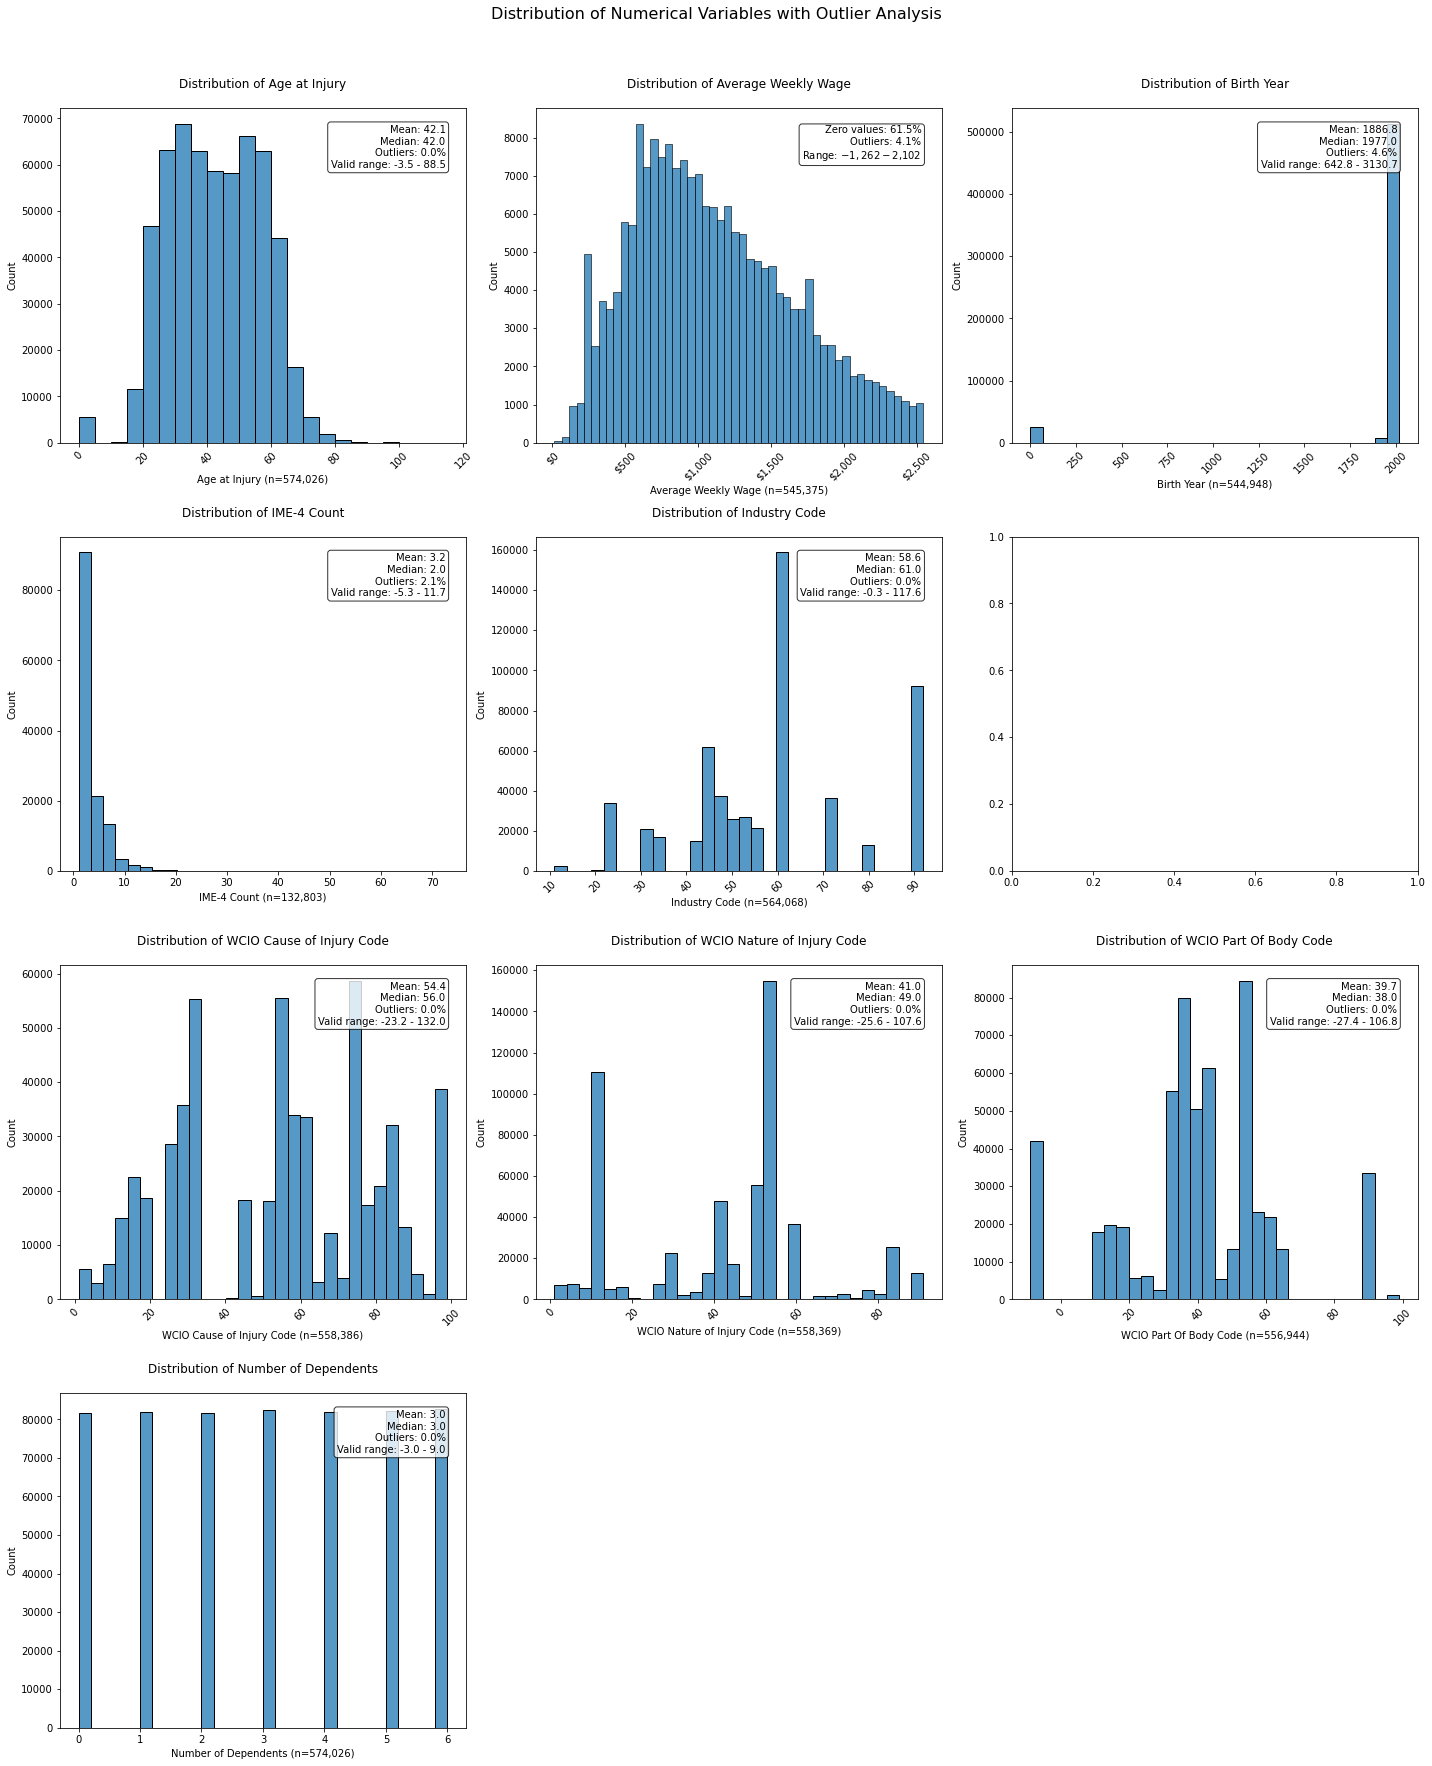

In [18]:
# Create visualizations for numerical features if verbose is set to True
if verbose:
    fig = create_histograms(train_df)
    plt.show()
    if verbose_2:
        print_distribution_stats(train_df)

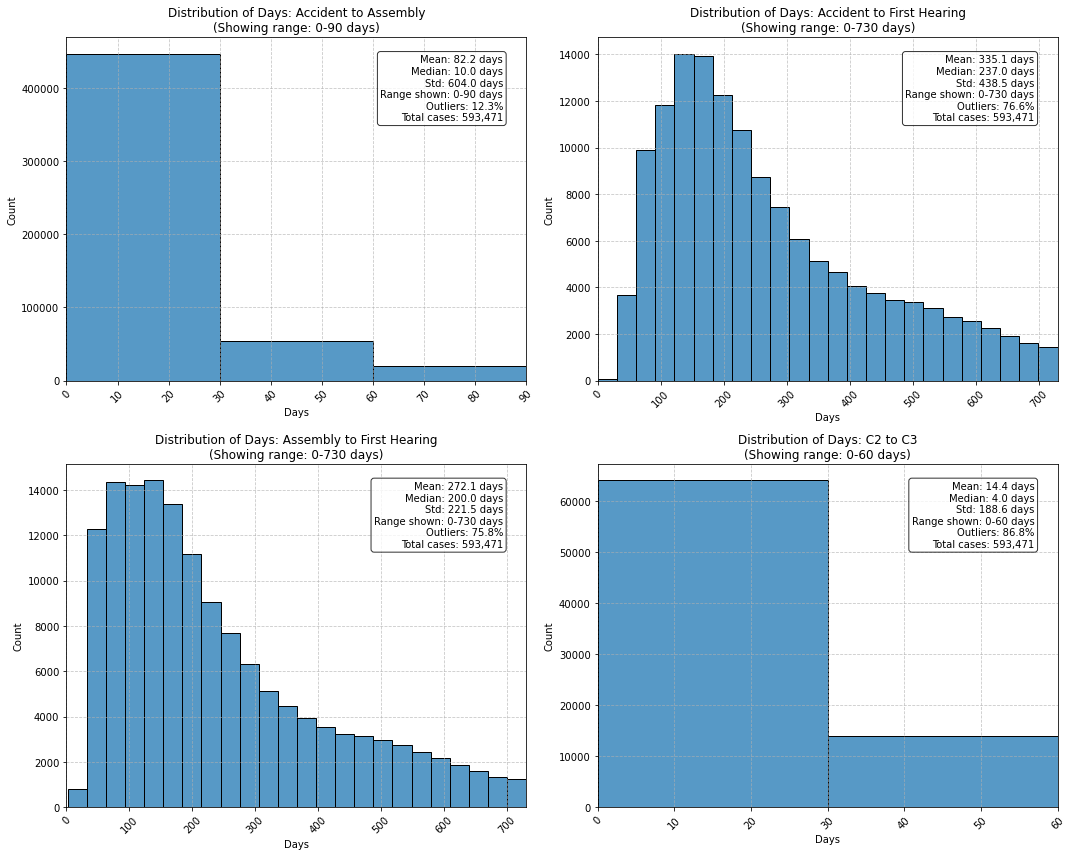

In [19]:
# Create visualizations for date intervals if verbose is set to True
if verbose:
    fig = analyze_date_intervals(train_df)
    plt.show()
    if verbose_2:
        print_interval_details(train_df)

## Categorical values

In [20]:
# Enhanced categorical analysis if verbose_2 is True
if verbose_2:
    enhanced_analysis = analyze_categorical_features_enhanced(train_df)

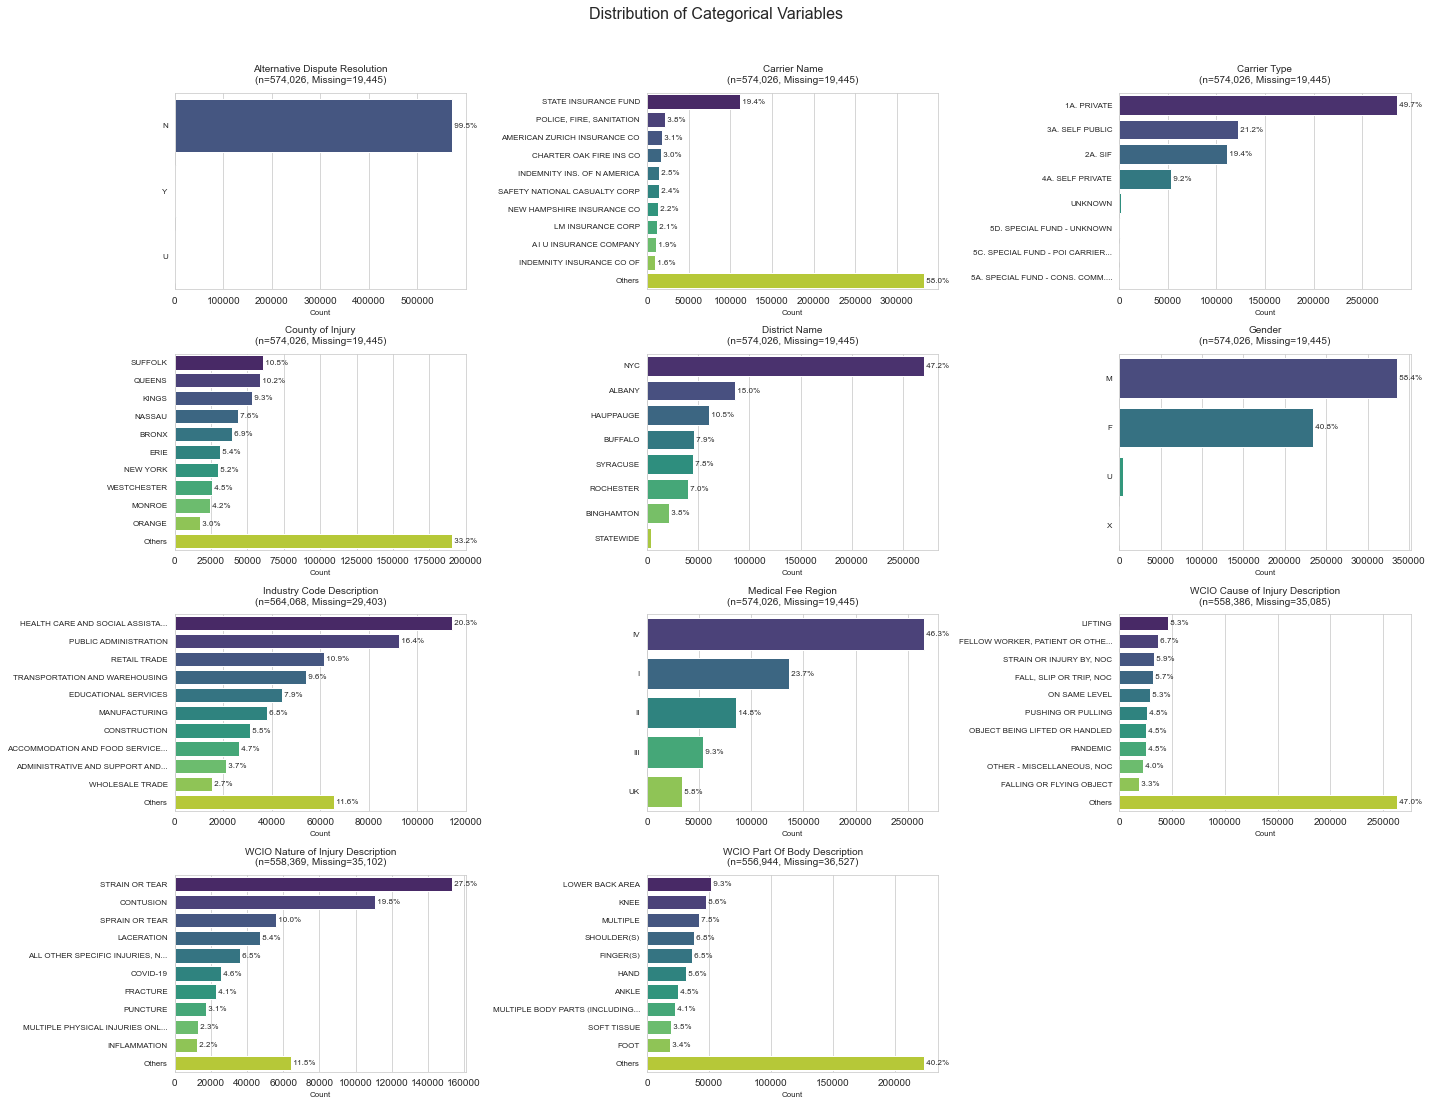

In [21]:
# Plot categorical feature distributions if verbose is set to True
if verbose:
    fig = plot_categorical_distributions(train_df)
    plt.show()

## Missing values and Dups

In [22]:
# Calculate missing percentage of each column in the training dataset
missing_percentage = train_df.isna().sum() / len(train_df) * 100
for col, percent in missing_percentage.items():
    if not percent == 0:
        print(f"{col}: {percent:.2f}% missing values")

Accident Date: 3.90% missing values
Age at Injury: 3.28% missing values
Alternative Dispute Resolution: 3.28% missing values
Attorney/Representative: 3.28% missing values
Average Weekly Wage: 8.10% missing values
Birth Year: 8.18% missing values
C-2 Date: 5.73% missing values
C-3 Date: 68.45% missing values
Carrier Name: 3.28% missing values
Carrier Type: 3.28% missing values
Claim Injury Type: 3.28% missing values
County of Injury: 3.28% missing values
COVID-19 Indicator: 3.28% missing values
District Name: 3.28% missing values
First Hearing Date: 74.59% missing values
Gender: 3.28% missing values
IME-4 Count: 77.62% missing values
Industry Code: 4.95% missing values
Industry Code Description: 4.95% missing values
Medical Fee Region: 3.28% missing values
OIICS Nature of Injury Description: 100.00% missing values
WCIO Cause of Injury Code: 5.91% missing values
WCIO Cause of Injury Description: 5.91% missing values
WCIO Nature of Injury Code: 5.91% missing values
WCIO Nature of Injury D

In [23]:
# Handle missing values in the target variable 'Claim Injury Type'
nan_count = train_df["Claim Injury Type"].isna().sum()
print(f"We found that {nan_count/train_df.shape[0] * 100}% of the training data has NAs on the target, therefore we will drop it.")
train_df = train_df.dropna(subset=["Claim Injury Type"])

We found that 3.276486972404717% of the training data has NAs on the target, therefore we will drop it.


#### See if there are duplicates on the dataset

In [24]:
# Identify duplicate rows in the training dataset
dup_rows = train_df.duplicated()
dup_rows[dup_rows == True]

Claim Identifier
5686771    True
dtype: bool

In [25]:
# Remove duplicate rows in the training dataset
train_df = train_df.drop_duplicates()

In [26]:
train_df.columns

Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type',
       'Claim Injury Type', 'County of Injury', 'COVID-19 Indicator',
       'District Name', 'First Hearing Date', 'Gender', 'IME-4 Count',
       'Industry Code', 'Industry Code Description', 'Medical Fee Region',
       'OIICS Nature of Injury Description', 'WCIO Cause of Injury Code',
       'WCIO Cause of Injury Description', 'WCIO Nature of Injury Code',
       'WCIO Nature of Injury Description', 'WCIO Part Of Body Code',
       'WCIO Part Of Body Description', 'Zip Code', 'Number of Dependents'],
      dtype='object')

In [27]:
# Identify rows where 'Alternative Dispute Resolution' has a value of "U" (unknown or irrelevant)
rows_u_adr = train_df[train_df["Alternative Dispute Resolution"] == "U"]
rows_u_adr
#only 5 rows with weird values

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Number of Dependents
Claim Identifier,,,,,,,,,,,,,,,,,,,,,
5582402,2018-03-12,57.0,U,2020-10-21,N,0.0,1961.0,NaN,NaN,ELECTRICAL EMPLOYERS,...,IV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10301,5.0
6032724,2021-11-05,56.0,U,2022-07-11,N,0.0,1965.0,NaN,NaN,ELECTRICAL EMPLOYERS,...,III,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10595,5.0
6034607,2022-07-06,52.0,U,2022-07-13,Y,0.0,1969.0,NaN,2023-03-09,ELECTRICAL EMPLOYERS,...,IV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11694,5.0
6108701,2022-09-01,57.0,U,2022-10-17,N,NaN,1965.0,NaN,NaN,ELECTRICAL EMPLOYERS,...,IV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11755,0.0
6108690,2022-08-29,55.0,U,2022-10-17,N,0.0,1967.0,NaN,NaN,ELECTRICAL EMPLOYERS,...,IV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11743,6.0


In [28]:
# Remove those rows
train_df.drop(rows_u_adr.index, inplace=True)

In [29]:
# Detect zip code anomalies (non-numeric values in a column that should be numeric)
zip_code_anomalies = train_df[train_df['Zip Code'].notna()  # 'Zip Code' is not missing
        & train_df['Zip Code'].apply(lambda x: not str(x).isnumeric())]  # 'Zip Code' is not numeric
zip_code_anomalies.head(3)

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Number of Dependents
Claim Identifier,,,,,,,,,,,,,,,,,,,,,
5399802,2019-12-21,25.0,N,2020-01-09,N,1631.50,0.0,2020-01-09,NaN,STATE INSURANCE FUND,...,UK,NaN,60.0,"STRAIN OR INJURY BY, NOC",52.0,STRAIN OR TEAR,52.0,UPPER LEG,L1N 5,0.0
5404203,2020-01-11,29.0,N,2020-01-16,Y,1401.17,0.0,2020-03-11,2021-07-01,ACE AMERICAN INSURANCE CO.,...,UK,NaN,75.0,FALLING OR FLYING OBJECT,10.0,CONTUSION,65.0,INSUFFICIENT INFO TO PROPERLY IDENTIFY - UNCLA...,T1B0P,5.0
5407348,2019-12-28,23.0,N,2020-01-17,N,0.00,0.0,2020-01-17,NaN,STATE INSURANCE FUND,...,UK,NaN,99.0,"OTHER - MISCELLANEOUS, NOC",7.0,CONCUSSION,18.0,SOFT TISSUE,L6Y 1,2.0


In [30]:
# Replace the anomalous zip codes with NaN
train_df.loc[train_df['Zip Code'].isin(zip_code_anomalies['Zip Code']), 'Zip Code'] = np.nan

# Replace "U" values in the 'Gender' column with "X" (presumably for unknown)
train_df["Gender"] = train_df["Gender"].replace("U","X")

In [31]:
# Fills the missing values in the "Age at Injury" column with the mean value of that column
train_df["Age at Injury"].fillna(train_df["Age at Injury"].mean(), inplace=True)

# Converts the 'Accident Date' column to datetime format. If there are errors during the conversion (like invalid values), they are turned into NaT (Not a Time).
train_df['Accident Date'] = pd.to_datetime(train_df['Accident Date'], errors='coerce')

# Fills missing values in the 'Birth Year' column by calculating the value as the year of 'Accident Date' minus 'Age at Injury'.
train_df['Birth Year'] = train_df['Birth Year'].fillna(
    train_df['Accident Date'].dt.year - train_df['Age at Injury'])

In [32]:
# US working age is at min 14 years old and retiring age is 64 years old, but will focus on people with less than 16 years

# Filters the rows where the "Age at Injury" is less than 16 and stores those rows in the variable "too_young"
# The filtering assumes that individuals under the age of 16 may not be relevant to the analysis.
too_young = train_df[train_df["Age at Injury"]<16]["Age at Injury"]

# The filtered rows (those with "Age at Injury" less than 16) are dropped from the DataFrame.
train_df.drop(too_young.index,inplace=True)

In [33]:
# Filters the rows where the "Birth Year" is less than 1903 and stores those rows in the variable "too_old"
# Individuals with a birth year earlier than 1903 are considered too old for the analysis, as the "Age at Injury" in the test set maxes out at 114 years old.
# While these individuals could technically be over 120 years old, the analysis assumes that the age at injury (rather than their actual birth year) is more relevant.
too_old = train_df[train_df["Birth Year"]<1903]["Birth Year"]

# Drops the rows where the "Birth Year" is less than 1903 from the DataFrame, as they are deemed irrelevant for the analysis.
train_df.drop(too_old.index, inplace=True)

In [35]:
# Replaces missing values (NaN) in the "IME-4 Count" column with 0.
# This step ensures that there are no missing values for "IME-4 Count", and any missing data is treated as zero occurrences.
train_df["IME-4 Count"].fillna(0,inplace=True)

# Creates a new column "Years Past Accident" by calculating the difference between the "Accident Date" and a reference date.
# The "Accident Date" is first converted to a datetime format, and any invalid dates are coerced into NaT (Not a Time).
# The difference between the accident date and the reference date is calculated in days, then divided by 365.25 to convert the difference to years (accounting for leap years).
train_df["Years Past Accident"] = (pd.to_datetime(train_df["Accident Date"], errors='coerce') - reference_date).dt.days / 365.25

In [36]:
# Limits the values in the "IME-4 Count" column to a maximum of 15.
# Any value greater than 15 is set to 15.
train_df.loc[train_df["IME-4 Count"] > 15, "IME-4 Count"] = 15

In [37]:
# Calculate the percentage of missing (NaN) values for each column in the train_df DataFrame.
missing_percentage = train_df.isna().sum() / len(train_df) * 100
for col, percent in missing_percentage.items():
    if not percent == 0:
        print(f"{col}: {percent:.2f}% missing values")

Average Weekly Wage: 4.99% missing values
C-2 Date: 2.10% missing values
C-3 Date: 67.71% missing values
First Hearing Date: 73.75% missing values
Industry Code: 1.46% missing values
Industry Code Description: 1.46% missing values
OIICS Nature of Injury Description: 100.00% missing values
WCIO Cause of Injury Code: 2.26% missing values
WCIO Cause of Injury Description: 2.26% missing values
WCIO Nature of Injury Code: 2.26% missing values
WCIO Nature of Injury Description: 2.26% missing values
WCIO Part Of Body Code: 2.45% missing values
WCIO Part Of Body Description: 2.45% missing values
Zip Code: 7.64% missing values


### Converting categorical variables to numerical
 We have to mind if they are nominal or ordinal

In [38]:
# Define columns to encode with different methods

# Features to encode using frequency encoding
features_to_encode_freq = ["Carrier Name", "County of Injury", "District Name", "Gender", "Medical Fee Region", "Zip Code"]

# Features to encode using binary encoding
features_to_encode_binary = ["Attorney/Representative", "COVID-19 Indicator", "Carrier Type", "Alternative Dispute Resolution"]

# Descriptive features to be used for analysis but not directly in model training
features_descriptions = ["Industry Code Description","WCIO Cause of Injury Description", "WCIO Cause of Injury Description",
                        "WCIO Nature of Injury Description", "WCIO Part Of Body Description", "OIICS Nature of Injury Description"]

# Features that need to be converted to dummy/indicator variables
features_to_dummy = ["First Hearing Date", "C-2 Date", "C-3 Date"]

# Features that will be transformed into 'days past' format (i.e., based on date)
features_to_days = ["Assembly Date"]

# Create a dictionary to store encoders
encoders_dict = {}


In [39]:
# Apply frequency encoding for categorical features
multiencoder(train_df, features_to_encode_freq, "frequency", encoders_dict)

# Apply binary encoding for categorical features
multiencoder(train_df, features_to_encode_binary, "binary", encoders_dict)

In [40]:
# Mapping the target classes to labels
class_mapping = {
    0: '1. CANCELLED',
    1: '2. NON-COMP',
    2: '3. MED ONLY',
    3: '4. TEMPORARY',
    4: '5. PPD SCH LOSS',
    5: '6. PPD NSL',
    6: '7. PTD',
    7: '8. DEATH'
}

In [41]:
# Initialize the LabelEncoder to encode the target variable
target_encoder = LabelEncoder()
target_encoder.classes_ = np.array(list(class_mapping.values()))
encoders_dict["Claim Injury Type"] = target_encoder

# Encode the target variable in the dataset
train_df["Claim Injury Type"] = target_encoder.transform(train_df["Claim Injury Type"])

#### Feature engineering and date to days/years

In [42]:
# Generate dummy variables for certain columns
gen_dummy(train_df,features_to_dummy)

In [43]:
# Create a new feature to represent the time difference (in years) from the reference date to the accident date
date_past_accident(train_df, features_to_days)

In [44]:
# Define columns to drop from the dataframe (descriptions, dummy columns, and date-related features)
features_to_drop = features_descriptions + features_to_days + features_to_dummy

# Drop the unnecessary columns from the dataframe
for feature in features_to_drop:
    try:
        train_df = train_df.drop(feature, axis = 1)
    except:
        print(f"{feature} no longer in train_df")

WCIO Cause of Injury Description no longer in train_df


In [45]:
# Calculate the percentage of missing values for each column
missing_percentage = train_df.isna().sum() / len(train_df) * 100
for col, percent in missing_percentage.items():
    if not percent == 0:
        print(f"{col}: {percent:.2f}% missing values")

Average Weekly Wage: 4.99% missing values
Industry Code: 1.46% missing values
WCIO Cause of Injury Code: 2.26% missing values
WCIO Nature of Injury Code: 2.26% missing values
WCIO Part Of Body Code: 2.45% missing values
Zip Code: 7.64% missing values


In [46]:
# Display basic information about the dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 545204 entries, 5393875 to 6165075
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Accident Date                   545204 non-null  datetime64[ns]
 1   Age at Injury                   545204 non-null  float64       
 2   Alternative Dispute Resolution  545204 non-null  int32         
 3   Attorney/Representative         545204 non-null  int32         
 4   Average Weekly Wage             518012 non-null  float64       
 5   Birth Year                      545204 non-null  float64       
 6   Carrier Name                    545204 non-null  float64       
 7   Carrier Type                    545204 non-null  int32         
 8   Claim Injury Type               545204 non-null  int32         
 9   County of Injury                545204 non-null  float64       
 10  COVID-19 Indicator              545204 non-null  

#### NAs found: 
- Average Weekly Wage: 4.99% missing values -> KNNimputer
- Industry Code: 1.46% missing values -> KNNimputer
- WCIO Cause of Injury Code: 2.26% missing values -> try with or without
- WCIO Nature of Injury Code: 2.26% missing values -> try with or without
- WCIO Part Of Body Code: 2.45% missing values -> try with or without
- Zip Code: 7.64% missing values -> try with or without

In [47]:
# Save the cleaned and processed data to a new CSV file
train_df.to_csv("train_data_after_EDA.csv")